# Protein structure prediction

This notebook showcases three physics-inspired methods to predict the 3D structure of a family of proteins starting from a Multiple Sequence Alignment (MSA).
A MSA is a set of amino-acid sequences that known to be found in nature to proteins of the same family. These sequences have been modified by means operations such as deletion of one amino-acid, insertion of a gap, in order to be "as aligned as possible". More details on MSA's on [wikipedia](https://en.wikipedia.org/wiki/Multiple_sequence_alignment). 

In practice, we are given a dataset where each row is a sequence of $L$ amino-acids, each sequence corresponding to one instance of the protein family. 
The idea, going under the name of [Direct Coupling Analysis (DCA)](https://en.wikipedia.org/wiki/Direct_coupling_analysis), is to make the hypothesis that these data were sampled from an unknown probability distribution over sequences $x_1, \ldots, x_L$ which is factorized in terms of pairwise interactions
$$
p(x_1, \ldots, x_L) \propto \prod_{1\le i<j\le L} \psi_{ij}(x_i,x_j).
$$
Reconstructing the parameters in the $\psi$ factors means tracing back which pairs of sites are interacting more strongly with each other.
This is, finally, a proxy to predict which sites are in contact in the 3D structure of the protein.

_Mathematical note:_ what I find interesting about Direct Coupling Analysis is that one could think that pairwise correlation are the right object to look at in order to reconstruct the contact map. However, large correlations simply do not imply strong interactions, and vice-versa. As an example, in a Gaussian distribution the correlation matrix and the coupling matrix are inverse of one another!

In summary, this is an inverse problem where **the goal is to infer the parameters of a distribution from samples**.
As a test, we will compare the result against data about the 3D structure of the protein encoded in terms of distances between each pair of sites.

We will use here three approximate methods to solve this problem, all inspired by statistical physics techniques:
- [Gaussian DCA (GaussDCA)](https://arxiv.org/abs/1404.1240): makes the approximation of trading discrete variables (amino-acids can take 1 of 20 values) for continuous ones, for which the corresponding inference problem can be solved exactly.
- [Pseudo-likelihood maximization DCA (PlmDCA)](https://arxiv.org/abs/1401.4832): instead of maximizing the likelihood of the data given the distribution, this approach maximizes a slightly different quantity, the "pseudo-likelihood", which offers considerable computational advantages.
- [Autoregressive DCA (ArDCA)](https://arxiv.org/abs/2103.03292): this is a machine learning approach. The distribution is re-written as a product of conditional distributions, each parametrized by an autoregressive neural network $^1$. This model has the advantage that generating new samples from the learned distribution is straightforward.

$^1$ This method is not explicitly parametrizing the pairwise interactions, it's rather using a black-box approach. However there are ways to estimate interactions, as explained in the paper.

## Setup

We set a few parameters:
- `family`: the protein family to be used. Available options are PF00014, PF00072, PF00076, PF00595, PF11354.
- `min_separation`: it is customary to neglect interactions between sites that are less than `min_separation` sites away along the chain, as they are considered to be trivial.
- `thresh_distance`: when dealing with the actual protein structure,two sites are considered to be bound if they are are less than `thresh_distance` (measure in Amstrong) apart.

Feel free to explore what happens with different values!

In [4]:
family = "PF00014"

min_separation = 5

thresh_distance = 8

8

We start by loading the necessary dependencies and checking the number of available threads.
The packages we will use leverage parallel computing, so if possible consider running this notebook on multiple threads.

In [5]:
import Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `c:\Users\sky_9\projects\ProteinStructurePrediction`
Precompiling project...
           ✗ MKL_jll
  0 dependencies successfully precompiled in 19 seconds. 435 already precompiled.


In [6]:
Base.Threads.nthreads()

8

First, we read the Multiple Sequence Alignment file and the 3D structure file

In [7]:
using FastaIO
using DelimitedFiles

dirname = "./data/$family"
fasta_file_compressed = "$dirname/$(family)_mgap6.fasta.gz"
fasta_file = "$dirname/$(family)_mgap6.fasta"
struct_file ="$dirname/$(family)_struct.dat"
if !isdir(dirname)
    error("Directory $dirname does not exist.")
end
isfile(fasta_file_compressed) || error("Fasta file $fasta_file_compressed does not exist.")
isfile(struct_file) || error("Struct file $struct_file does not exist.")
f = readfasta(fasta_file_compressed)
nsequences = length(f)
writefasta("$(dirname)/$(family)_mgap6.fasta", f)

X = readdlm(struct_file)[:,[1,2,4]]
nsites = Int(maximum(X[:,1:2]))

score_true = [(Int(i), Int(j), v) for (i,j,v) in eachrow(X) 
                if abs(i-j) ≥ min_separation && v < thresh_distance]
sort!(score_true, by=x->x[3])

println("MSA for protein family $family")
println("Sequence length (number of sites): $nsites")
println("Number of sequences: $nsequences")

MSA for protein family PF00014
Sequence length (number of sites): 53
Number of sequences: 13600


## Contact prediction

Now we run the three methods on the input data. This can take some time depending on the size of the selected family.
I recommend starting with PF00014 which is the smallest one.

Each method outpus a vector whose elements look like `(site_i, site_j, binding_score)`, where the binding score is a measure of how strongly sites $i$ and $j$ are predicted to interact. 
The vector is sorted in descending order of score.

In [11]:
using GaussDCA

score_gauss = gDCA(fasta_file_compressed; min_separation);

θ = 0.32759600382237447 threshold = 17.0
M = 13600 N = 53 Meff = 2939.452266277389


PlmDCA and ArDCA receive some regularization parameters as input: $\lambda_J$ and $\lambda_H$, which control weight decay for the parameters to be inferred

In [12]:
using PlmDCA

res = plmdca(fasta_file_compressed; verbose=true, 
    min_separation, lambdaJ=0.02, lambdaH=0.001)
score_plm = res.score;

removing duplicate sequences... done: 13600 -> 8871
θ = 0.3308846126401105 threshold = 17.0
M = 8871 N = 53 Meff = 2950.925530761646
preprocessing took 0.4250809 seconds
site = 48	 pl = 0.0858	 time = 2.8804	exit status = FTOL_REACHED
site = 1	 pl = 1.6201	 time = 4.0939	exit status = FTOL_REACHED
site = 42	 pl = 0.3008	 time = 4.1597	exit status = FTOL_REACHED
site = 22	 pl = 2.5350	 time = 4.7370	exit status = FTOL_REACHED
site = 15	 pl = 2.3852	 time = 4.8489	exit status = FTOL_REACHED
site = 36	 pl = 2.0149	 time = 5.2564	exit status = FTOL_REACHED
site = 29	 pl = 2.3740	 time = 5.4489	exit status = FTOL_REACHED
site = 8	 pl = 2.4861	 time = 5.7881	exit status = FTOL_REACHED
site = 49	 pl = 2.1664	 time = 4.9976	exit status = FTOL_REACHED
site = 2	 pl = 0.1705	 time = 4.5914	exit status = FTOL_REACHED
site = 43	 pl = 2.4862	 time = 5.0590	exit status = FTOL_REACHED
site = 37	 pl = 0.6355	 time = 4.1462	exit status = FTOL_REACHED
site = 23	 pl = 2.5738	 time = 5.3813	exit status = F

In [13]:
using ArDCA

arnet, arvar = ardca(fasta_file_compressed, verbose=true, lambdaJ=0.02, lambdaH=0.001)

# ArDCA requires one sequence to be taken as reference for the computation of the score
# It turns out that this choice has little impact on the outcome
reference_sequence_index = 1
score_ar = epistatic_score(arnet, arvar, reference_sequence_index; min_separation);

removing duplicate sequences... done: 13600 -> 8871
θ = 0.3308846126401105 threshold = 17.0
M = 8871 N = 53 Meff = 2950.925530761646
site = 48	pl = 0.0996	time = 2.2416	status = FTOL_REACHED
site = 52	pl = 0.1976	time = 0.2984	status = FTOL_REACHED
site = 30	pl = 0.5179	time = 2.8128	status = FTOL_REACHED
site = 40	pl = 0.1890	time = 0.3072	status = FTOL_REACHED
site = 2	pl = 0.2888	time = 0.4173	status = FTOL_REACHED
site = 18	pl = 1.2028	time = 3.4471	status = FTOL_REACHED
site = 11	pl = 0.7186	time = 0.9514	status = FTOL_REACHED
site = 42	pl = 0.3433	time = 0.6016	status = FTOL_REACHED
site = 9	pl = 0.4811	time = 0.7261	status = FTOL_REACHED
site = 1	pl = 1.7230	time = 4.8091	status = FTOL_REACHED
site = 37	pl = 0.7271	time = 1.1604	status = FTOL_REACHED
site = 21	pl = 1.2504	time = 1.5891	status = FTOL_REACHED
site = 25	pl = 2.2007	time = 5.1159	status = FTOL_REACHED
site = 34	pl = 0.4775	time = 0.6930	status = FTOL_REACHED
site = 28	pl = 2.2504	time = 5.8635	status = FTOL_REACHED


## Save intermediate files for convenience

In [14]:
using JLD2

jldsave("scores.jld2"; score_gauss, score_plm, score_ar)

In [15]:
using JLD2, UnPack

data = load("scores.jld2")
@unpack score_gauss, score_plm, score_ar = data;

## Plotting results

In order to assess the goodness of the methods, we produce two kinds of plot:
- A **contact map** which compares visually the "true" contact along the chain as extracted from the 3D information against the predicted contacts. Typically, for the prediction, one only plots the best-ranked $2L$ contacts, i.e. the ones that the model predicts with more confidence ($L$ here is the length of the protein domain measured in number of sites).
- A **Positive Predicted Values** curve where a point `(x,y)` means that among the `x` best-ranked contacts, a ration of `y` were true contacts, i.e. are also found in the 3D structure. 

In [16]:
using CairoMakie

CairoMakie.activate!(inline=true)

In [17]:
function iscontact(residue_and_score, score_true)
    i, j = residue_and_score
    return any(s -> extrema((i,j)) == extrema(s[1:2]), score_true)
end

function find_false_positives(score, score_true; ncontacts = length(score))
    @assert ncontacts ≤ length(score)
    X = zeros(Int, 0); Y = zeros(Int, 0)

    for (i,j,v) in score[1:ncontacts]
        if !iscontact((i,j,v), score_true)
            push!(X, max(i,j))
            push!(Y, min(i,j))
        end
    end
    return X, Y
end

find_false_positives (generic function with 1 method)

In [18]:
function plot_contact_map!(ax, score::Vector{Tuple{Int, Int, Float64}};
        ncontacts = lenght(score), upper=false,
        false_positives = [],
        color=:black, markersize=4, label="",
        color_fp=:red, label_fp="False positives")

    @assert ncontacts ≤ length(score)
    X = zeros(Int, ncontacts); Y = zeros(Int, ncontacts)
    for id in 1:ncontacts
        i, j, v = score[id]
        if upper
            X[id] = min(i,j); Y[id] = max(i,j)
        else
            X[id] = max(i,j); Y[id] = min(i,j)
        end
    end

    scatter!(ax, X, Y; color, markersize, label)

    if !isempty(false_positives)
        Xfp, Yfp = false_positives
        scatter!(ax, Xfp, Yfp; label=label_fp, color=color_fp, markersize)
    end

    return ax
end

plot_contact_map! (generic function with 1 method)

In [31]:
function plot_contacts_vs_true(score, score_true; 
        ncontacts=length(score), label="",
        )

    fig = Figure(size=(450, 300))
    false_positives = find_false_positives(score, score_true; ncontacts)
        
    ax = Axis(fig[1, 1]; limits=((0,nsites),(0,nsites)),
        xlabel="site", ylabel="site")

    plot_contact_map!(ax, score_true, ncontacts=length(score_true), upper=true, 
        label = "True contacts")
    plot_contact_map!(ax, score; ncontacts, color=:blue,
        label, false_positives)

    lines!(ax, min_separation:nsites, 
        (min_separation:nsites) .- min_separation, 
        color=(:gray, 0.5), linewidth=0.5)
    lines!(ax, (min_separation:nsites) .- min_separation,
        min_separation:nsites,  
        color=(:gray, 0.5), linewidth=0.5)
        
    leg = Legend(fig[1,2], ax)
    for i in eachindex(leg.entrygroups[][1][2])
        leg.entrygroups[][1][2][i].elements[1].attributes[:markersize] = Observable(6)
    end
    notify(leg.entrygroups)

    fig
end

plot_contacts_vs_true (generic function with 1 method)

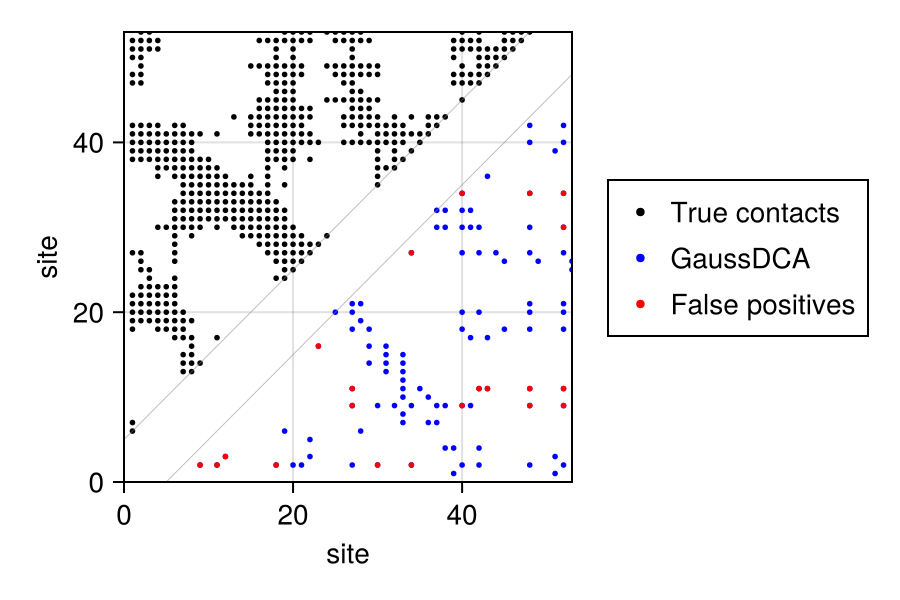

In [33]:
plot_contacts_vs_true(score_gauss, score_true; ncontacts=2nsites, label="GaussDCA")

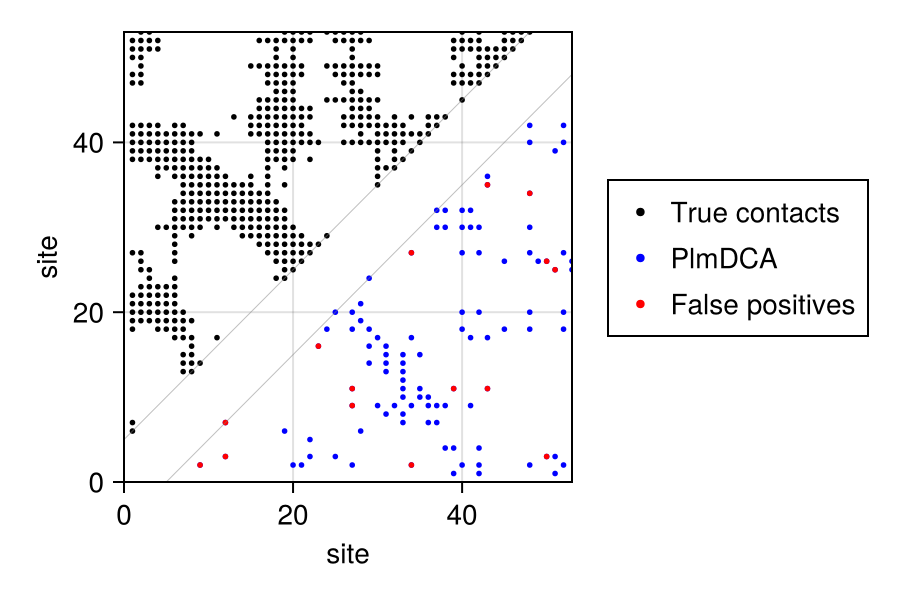

In [34]:
plot_contacts_vs_true(score_plm, score_true; ncontacts=2nsites, label="PlmDCA")

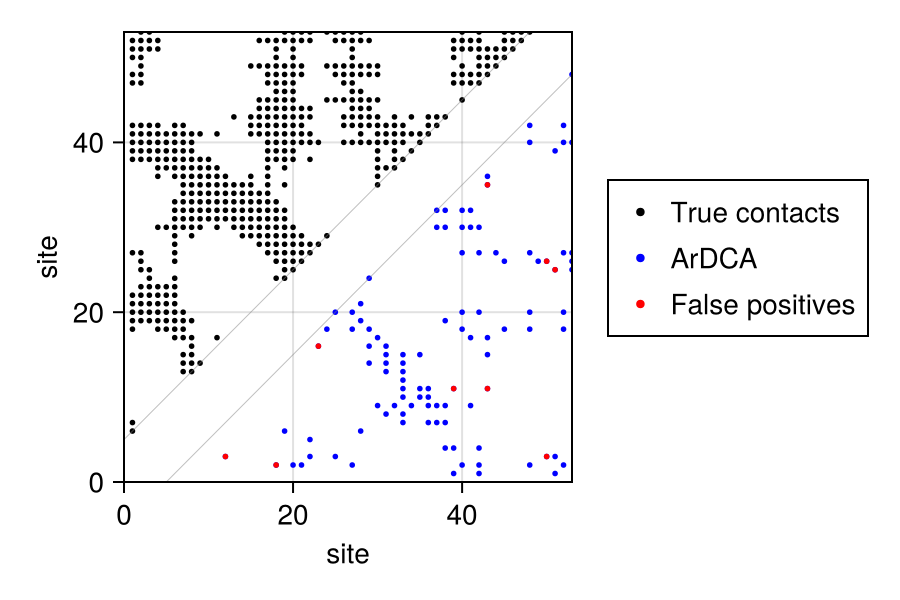

In [35]:
plot_contacts_vs_true(score_ar, score_true; ncontacts=2nsites, label="ArDCA")

In [36]:
function roc(score, score_true)
    out = zeros(length(score_true))
    n_true_positives = 0

    for n in eachindex(score_true)
        if iscontact(score[n], score_true)
            n_true_positives += 1
        end
        out[n] = n_true_positives / n
    end
    return out
end

roc (generic function with 1 method)

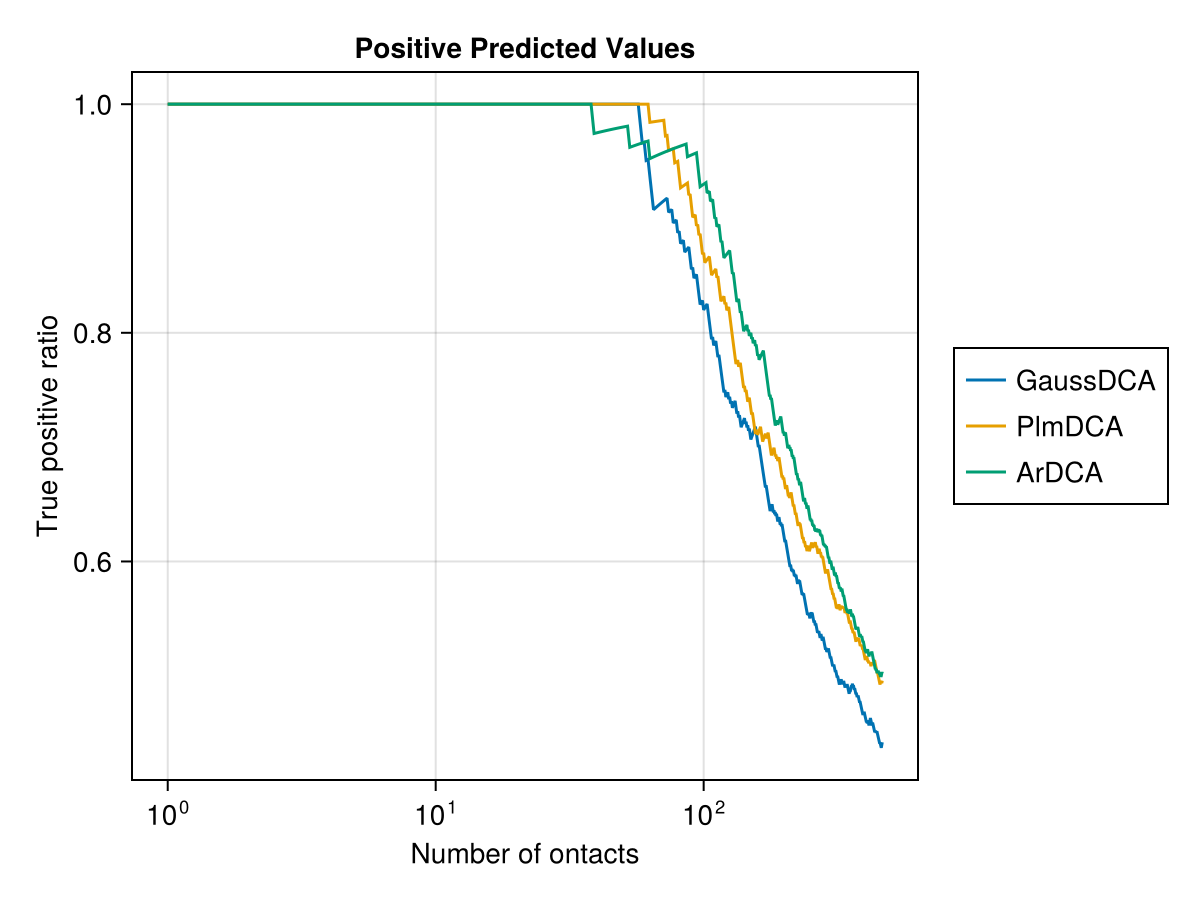

In [37]:
fig_roc = Figure(figsize=(600,400))
ax = Axis(fig_roc[1, 1];
            xlabel = "Number of ontacts", ylabel = "True positive ratio",
            xscale=log10, title="Positive Predicted Values")

for (score, label) in zip([score_gauss, score_plm, score_ar], ["GaussDCA", "PlmDCA", "ArDCA"])
    lines!(ax, roc(score, score_true); label)
end

fig_roc[1,2] = Legend(fig_roc, ax)

fig_roc

**Interpretation**: the fact that all of the three curves start horizontal means that the $\sim 30$ highest-ranked contacts found by all of the methods were also found in the 3D structure.

## Conclusions

Direct Coupling Analysis provides an effective framework to reconstruct protein structure starting from sequences and, potentially, to generate new functional proteins. 
Although these methods were to some extent made obsolete by tools such as AlphaFold, they surely have the advantage of interpretability.